# Borrowing Capacity

This notebook calculates the book borrowing capacity for members of the S&Co library.  Since library memberships defined a limit on the amount of books a person could borrow at a time (typically only one), we define the borrowing capacity of the library as the total number of books that could be checked out at any given time based on the active subscriptions.

This code helps us generate figure 7 for our paper.

## Load Libraries & Datasets

In [1]:
import pandas as pd

import sys
sys.path.append('..')

from utils.missing_data_processing import *
events_df, members_df, books_df, _  = load_initial_data()


## limit to events with complete start and end dates

In [3]:
# subset data for only those with complete start and end dates
date_events = events_df[(events_df.start_date.str.len() > 9) & (events_df.end_date.str.len() > 9)].copy()
# turn start/end dates into datetimes
date_events['start_datetime'] = pd.to_datetime(date_events.start_date, format='%Y-%m-%d', errors='ignore')
date_events['end_datetime'] = pd.to_datetime(date_events.end_date, format='%Y-%m-%d', errors='ignore')
date_events = date_events.sort_values(by=['start_datetime'])
date_events.head()

event_type  start_date    end_date  \
671    Subscription  1919-11-17  1919-12-17   
29915  Subscription  1919-11-17  1920-11-17   
29914  Subscription  1919-11-17  1920-02-17   
674          Borrow  1919-11-18  1919-11-28   
29916  Subscription  1919-11-18  1920-05-18   

                                             member_uris  \
671    https://shakespeareandco.princeton.edu/members...   
29915  https://shakespeareandco.princeton.edu/members...   
29914  https://shakespeareandco.princeton.edu/members...   
674    https://shakespeareandco.princeton.edu/members...   
29916  https://shakespeareandco.princeton.edu/members...   

                           member_names member_sort_names  \
671    Claude Cahun / Mlle Lucie Schwob     Cahun, Claude   
29915                     Marcelle Flot    Flot, Marcelle   
29914                     Mrs. Worthing    Worthing, Mrs.   
674                       Denise Ulmann    Ulmann, Denise   
29916                        Anne Evans       Evans, Anne   

       subscription_price_paid  subscription_deposit subscription_duration  \
671                        4.0                   NaN               1 month   
29915                     28.0                   NaN                1 year   
29914                     12.0                   NaN              3 months   
674                        NaN                   NaN                   NaN   
29916                     35.0                  14.0              6 months   

       subscription_duration_days  ...  item_volume  item_authors item_year  \
671                          30.0  ...          NaN           NaN       NaN   
29915                       366.0  ...          NaN           NaN       NaN   
29914                        92.0  ...          NaN           NaN       NaN   
674                           NaN  ...          NaN  Wilde, Oscar    1905.0   
29916                       182.0  ...          NaN           NaN       NaN   

       item_notes                   source_type  \
671           NaN  Lending Library Card;Logbook   
29915         NaN                       Logbook   
29914         NaN                       Logbook   
674           NaN          Lending Library Card   
29916         NaN                       Logbook   

                                         source_citation  \
671    Sylvia Beach, Lucie Schwob Lending Library Car...   
29915  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
29914  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
674    Sylvia Beach, Mlle Denise Ulmann Lending Libra...   
29916  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   

                                         source_manifest  \
671    https://figgy.princeton.edu/concern/scanned_re...   
29915                                                NaN   
29914                                                NaN   
674    https://figgy.princeton.edu/concern/scanned_re...   
29916                                                NaN   

                                            source_image start_datetime  \
671    https://iiif.princeton.edu/loris/figgy_prod/3a...     1919-11-17   
29915                                                NaN     1919-11-17   
29914                                                NaN     1919-11-17   
674    https://iiif.princeton.edu/loris/figgy_prod/86...     1919-11-18   
29916                                                NaN     1919-11-18   

      end_datetime  
671     1919-12-17  
29915   1920-11-17  
29914   1920-02-17  
674     1919-11-28  
29916   1920-05-18  

[5 rows x 30 columns]

In [4]:
earliest_date = date_events.start_datetime.iloc[0]
earliest_date

Timestamp('1919-11-17 00:00:00')

## separate out borrow events and subscription events

In [5]:
# borrow events 
borrow_events = date_events[date_events.event_type == 'Borrow']

In [6]:
# subset data for subscription events with complete dates
subscription_events = date_events[date_events.event_type.isin(['Subscription', 'Renewal', 'Supplement'])]
subscription_events.head()

event_type  start_date    end_date  \
671    Subscription  1919-11-17  1919-12-17   
29915  Subscription  1919-11-17  1920-11-17   
29914  Subscription  1919-11-17  1920-02-17   
29916  Subscription  1919-11-18  1920-05-18   
672    Subscription  1919-11-18  1919-12-18   

                                             member_uris  \
671    https://shakespeareandco.princeton.edu/members...   
29915  https://shakespeareandco.princeton.edu/members...   
29914  https://shakespeareandco.princeton.edu/members...   
29916  https://shakespeareandco.princeton.edu/members...   
672    https://shakespeareandco.princeton.edu/members...   

                           member_names member_sort_names  \
671    Claude Cahun / Mlle Lucie Schwob     Cahun, Claude   
29915                     Marcelle Flot    Flot, Marcelle   
29914                     Mrs. Worthing    Worthing, Mrs.   
29916                        Anne Evans       Evans, Anne   
672                       Henri Regnier    Regnier, Henri   

       subscription_price_paid  subscription_deposit subscription_duration  \
671                        4.0                   NaN               1 month   
29915                     28.0                   NaN                1 year   
29914                     12.0                   NaN              3 months   
29916                     35.0                  14.0              6 months   
672                        4.0                   5.6               1 month   

       subscription_duration_days  ...  item_volume item_authors item_year  \
671                          30.0  ...          NaN          NaN       NaN   
29915                       366.0  ...          NaN          NaN       NaN   
29914                        92.0  ...          NaN          NaN       NaN   
29916                       182.0  ...          NaN          NaN       NaN   
672                          30.0  ...          NaN          NaN       NaN   

       item_notes                   source_type  \
671           NaN  Lending Library Card;Logbook   
29915         NaN                       Logbook   
29914         NaN                       Logbook   
29916         NaN                       Logbook   
672           NaN  Logbook;Lending Library Card   

                                         source_citation  \
671    Sylvia Beach, Lucie Schwob Lending Library Car...   
29915  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
29914  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
29916  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
672    Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   

                                         source_manifest  \
671    https://figgy.princeton.edu/concern/scanned_re...   
29915                                                NaN   
29914                                                NaN   
29916                                                NaN   
672    ;https://figgy.princeton.edu/concern/scanned_r...   

                                            source_image start_datetime  \
671    https://iiif.princeton.edu/loris/figgy_prod/3a...     1919-11-17   
29915                                                NaN     1919-11-17   
29914                                                NaN     1919-11-17   
29916                                                NaN     1919-11-18   
672    ;https://iiif.princeton.edu/loris/figgy_prod/c...     1919-11-18   

      end_datetime  
671     1919-12-17  
29915   1920-11-17  
29914   1920-02-17  
29916   1920-05-18  
672     1919-12-18  

[5 rows x 30 columns]

In [7]:
# end date for the last subscription
subs_end_date = subscription_events.end_datetime.max()
subs_end_date

Timestamp('1942-09-03 00:00:00')

In [8]:
day = subscription_events.start_datetime.iloc[0]
print(day)
subscription_events[(subscription_events.start_datetime <= day) & (day < subscription_events.end_datetime)].subscription_volumes.sum()

1919-11-17 00:00:00


3.0

In [9]:
subs_vol_totals = subscription_events.groupby(["subscription_volumes"]).size().reset_index(name='count').sort_values(['count'], ascending=False)
# alternately, can be generated more simply via
# subscription_events.subscription_volumes.value_counts()
subs_vol_totals

subscription_volumes  count
0                   1.0   6086
1                   2.0   2524
2                   3.0     58
3                   4.0     32
4                   5.0      2
5                   6.0      2
6                   7.0      1

In [10]:
subscription_events[subscription_events.subscription_volumes > 4]

event_type  start_date    end_date  \
30096  Subscription  1920-11-13  1920-12-13   
3640     Supplement  1923-12-27  1924-03-27   
4060        Renewal  1924-05-01  1924-06-01   
31329       Renewal  1924-06-10  1924-07-10   
22273  Subscription  1938-03-02  1938-04-02   

                                             member_uris  \
30096  https://shakespeareandco.princeton.edu/members...   
3640   https://shakespeareandco.princeton.edu/members...   
4060   https://shakespeareandco.princeton.edu/members...   
31329  https://shakespeareandco.princeton.edu/members...   
22273  https://shakespeareandco.princeton.edu/members...   

               member_names      member_sort_names  subscription_price_paid  \
30096  Mrs. Pierce Williams  Williams, Mrs. Pierce                     18.0   
3640          Mme Lowenfeld         Lowenfeld, Mme                     20.0   
4060      Colonel Thackeray     Thackeray, Colonel                     48.0   
31329         Mme Lowenfeld         Lowenfeld, Mme                     48.0   
22273       Ford Madox Ford       Ford, Ford Madox                     30.0   

       subscription_deposit subscription_duration  subscription_duration_days  \
30096                   NaN               1 month                        30.0   
3640                    NaN              3 months                        91.0   
4060                    NaN               1 month                        31.0   
31329                   NaN               1 month                        30.0   
22273                  20.0               1 month                        31.0   

       ...  item_volume item_authors item_year  item_notes  \
30096  ...          NaN          NaN       NaN         NaN   
3640   ...          NaN          NaN       NaN         NaN   
4060   ...          NaN          NaN       NaN         NaN   
31329  ...          NaN          NaN       NaN         NaN   
22273  ...          NaN          NaN       NaN         NaN   

                source_type  \
30096               Logbook   
3640                Logbook   
4060                Logbook   
31329               Logbook   
22273  Lending Library Card   

                                         source_citation  \
30096  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
3640   Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
4060   Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
31329  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
22273  Sylvia Beach, Ford Madox Ford Lending Library ...   

                                         source_manifest  \
30096                                                NaN   
3640                                                 NaN   
4060                                                 NaN   
31329                                                NaN   
22273  https://figgy.princeton.edu/concern/scanned_re...   

                                            source_image start_datetime  \
30096                                                NaN     1920-11-13   
3640                                                 NaN     1923-12-27   
4060                                                 NaN     1924-05-01   
31329                                                NaN     1924-06-10   
22273  https://iiif.princeton.edu/loris/figgy_prod/b9...     1938-03-02   

      end_datetime  
30096   1920-12-13  
3640    1924-03-27  
4060    1924-06-01  
31329   1924-07-10  
22273   1938-04-02  

[5 rows x 30 columns]

## report on number of events excluded

In [11]:
# subset data for only those with complete start and end dates
# - completely missing
no_dates = events_df[events_df.start_date.isna() & events_df.end_date.isna()]
no_start = events_df[events_df.start_date.isna() & events_df.end_date.notna()]
no_end = events_df[events_df.start_date.notna() & events_df.end_date.isna()]

# - partially missing
partial_dates = events_df[(events_df.start_date.str.len() < 10) & (events_df.end_date.str.len() < 10)]
partial_start = events_df[(events_df.start_date.str.len() < 10) & (events_df.end_date.str.len() >= 10)]
partial_end = events_df[(events_df.start_date.str.len() >= 10) & (events_df.end_date.str.len() < 10)]

excluded_events = pd.DataFrame([
  ['no_dates', len(no_dates)],
  ['no_start', len(no_start)],
  ['no_end', len(no_end)],
  ['partial_dates', len(partial_dates)],
  ['partial_start', len(partial_start)],
  ['partial_end', len(partial_end)]
], columns=["label", "count"])
print('Excluded events, any type')
excluded_events

Excluded events, any type


label  count
0       no_dates    383
1       no_start     36
2         no_end   2072
3  partial_dates    190
4  partial_start    108
5    partial_end    136

### excluded borrow events

In [12]:
# report on excluded events for borrows
excluded_borrows = pd.DataFrame([
  ['no_dates', len(no_dates[no_dates.event_type == 'Borrow'])],
  ['no_start', len(no_start[no_start.event_type == 'Borrow'])],
  ['no_end', len(no_end[no_end.event_type == 'Borrow'])],
  ['partial_dates', len(partial_dates[partial_dates.event_type == 'Borrow'])],
  ['partial_start', len(partial_start[partial_start.event_type == 'Borrow'])],
  ['partial_end', len(partial_end[partial_end.event_type == 'Borrow'])]
], columns=["label", "count"])
print('Excluded borrows')
excluded_borrows


Excluded borrows


label  count
0       no_dates      6
1       no_start     36
2         no_end    929
3  partial_dates     55
4  partial_start    108
5    partial_end    136

### excluded subscription events

In [13]:
# report on excluded events for subscriptions 
excluded_subscriptions = pd.DataFrame([
  ['no_dates', len(no_dates[no_dates.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])],
  ['no_start', len(no_start[no_start.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])],
  ['no_end', len(no_end[no_end.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])],
  ['partial_dates', len(partial_dates[partial_dates.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])],
  ['partial_start', len(partial_start[partial_start.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])],
  ['partial_end', len(partial_end[partial_end.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])]
], columns=["label", "count"])
print('Excluded subscriptions')
excluded_subscriptions

Excluded subscriptions


label  count
0       no_dates      1
1       no_start      0
2         no_end    635
3  partial_dates    110
4  partial_start      0
5    partial_end      0

# calculate borrowing capacity

## generated filtered subscription set for members with cards

Members with extant cards won't filter exactly as needed, since we know there are some members with partial borrowing history, but should a useful first look at borrowing capacity

In [14]:
member_subs = subscription_events.copy()
member_subs[['first_member_uri','second_member_uri']] = member_subs.member_uris.str.split(';', expand=True)
# handle multiple member uris (joint accounts) in subscriptions by merging on the first one (has card should be same)
member_subs = pd.merge(left=member_subs, right=members_df, left_on="first_member_uri", right_on="uri")
member_subs = member_subs[member_subs.has_card]
member_subs


event_type  start_date    end_date  \
0     Subscription  1919-11-17  1919-12-17   
19    Subscription  1919-11-18  1919-12-18   
20    Subscription  1919-11-18  1919-12-18   
22    Subscription  1919-11-19  1920-05-19   
23         Renewal  1920-05-19  1920-11-19   
...            ...         ...         ...   
9072  Subscription  1941-11-28  1941-12-28   
9073  Subscription  1941-11-28  1941-12-28   
9074  Subscription  1941-11-28  1941-12-28   
9075  Subscription  1941-11-28  1941-12-28   
9078  Subscription  1941-12-05  1942-01-05   

                                            member_uris  \
0     https://shakespeareandco.princeton.edu/members...   
19    https://shakespeareandco.princeton.edu/members...   
20    https://shakespeareandco.princeton.edu/members...   
22    https://shakespeareandco.princeton.edu/members...   
23    https://shakespeareandco.princeton.edu/members...   
...                                                 ...   
9072  https://shakespeareandco.princeton.edu/members...   
9073  https://shakespeareandco.princeton.edu/members...   
9074  https://shakespeareandco.princeton.edu/members...   
9075  https://shakespeareandco.princeton.edu/members...   
9078  https://shakespeareandco.princeton.edu/members...   

                          member_names      member_sort_names  \
0     Claude Cahun / Mlle Lucie Schwob          Cahun, Claude   
19                       Henri Regnier         Regnier, Henri   
20                       Denise Ulmann         Ulmann, Denise   
22                     Maurice Oerthel       Oerthel, Maurice   
23                     Maurice Oerthel       Oerthel, Maurice   
...                                ...                    ...   
9072                      Jean Pierret          Pierret, Jean   
9073                     Robert Gillet         Gillet, Robert   
9074                Bernard Lestocquoy    Lestocquoy, Bernard   
9075              Christianne Mingalon  Mingalon, Christianne   
9078                   Martine Lacorne       Lacorne, Martine   

      subscription_price_paid  subscription_deposit subscription_duration  \
0                         4.0                   NaN               1 month   
19                        4.0                   5.6               1 month   
20                        6.4                  11.2               1 month   
22                       16.0                   NaN              6 months   
23                       16.0                   NaN              6 months   
...                       ...                   ...                   ...   
9072                     20.0                  50.0               1 month   
9073                     20.0                  50.0               1 month   
9074                     25.0                  50.0               1 month   
9075                     25.0                  50.0               1 month   
9078                     20.0                  50.0               1 month   

      subscription_duration_days  ...  membership_years  \
0                           30.0  ...              1919   
19                          30.0  ...              1919   
20                          30.0  ...              1919   
22                         182.0  ...    1920;1921;1919   
23                         184.0  ...    1920;1921;1919   
...                          ...  ...               ...   
9072                        30.0  ...              1941   
9073                        30.0  ...              1941   
9074                        30.0  ...              1941   
9075                        30.0  ...              1941   
9078                        31.0  ...         1941;1942   

                           viaf_url  \
0     http://viaf.org/viaf/19757660   
19                              NaN   
20                              NaN   
22                              NaN   
23                              NaN   
...                             ...   
9072                            NaN   
9073               

## calculate total books out and subscription volumes per day

In [15]:
from datetime import date, timedelta
# arbritrary end date while testing
#end_day = date(1925, 6, 1)
# go through end of last subscription end date
#end_day = subs_end_date
one_day = timedelta(days=1)
# start with the earliest start date
day = date_events.start_datetime.iloc[0]

dates = []
books_out = []
subscription_vols = []
card_subscription_vols = []

while day < subs_end_date:
    dates.append(day)
    # get total number of borrowing events spanning this date; include start date, exclude end (to avoid double counting)
    books_out.append(len(borrow_events[(borrow_events.start_datetime <= day) & (borrow_events.end_datetime > day)]))
    # total number of volumes from active subscriptions for this date
    subscription_vols.append(subscription_events[(subscription_events.start_datetime <= day) & (day < subscription_events.end_datetime)].subscription_volumes.sum())
    # total number of volumes from subscriptions for members with extant cards
    card_subscription_vols.append(member_subs[(member_subs.start_datetime <= day) & (day < member_subs.end_datetime)].subscription_volumes.sum())

    day += one_day

borrowing_df  = pd.DataFrame()
borrowing_df['date'] = dates
borrowing_df['books_out'] = books_out
borrowing_df['subscription_volumes'] = subscription_vols
borrowing_df['card_subscription_volumes'] = card_subscription_vols
borrowing_df

date  books_out  subscription_volumes  card_subscription_volumes
0    1919-11-17          0                   3.0                        1.0
1    1919-11-18          3                   9.0                        4.0
2    1919-11-19          5                  10.0                        5.0
3    1919-11-20          5                  11.0                        5.0
4    1919-11-21          5                  13.0                        5.0
...         ...        ...                   ...                        ...
8321 1942-08-29         17                   1.0                        1.0
8322 1942-08-30         17                   1.0                        1.0
8323 1942-08-31         17                   1.0                        1.0
8324 1942-09-01         17                   1.0                        1.0
8325 1942-09-02         17                   1.0                        1.0

[8326 rows x 4 columns]

### chart: daily books out vs total subscription volumes

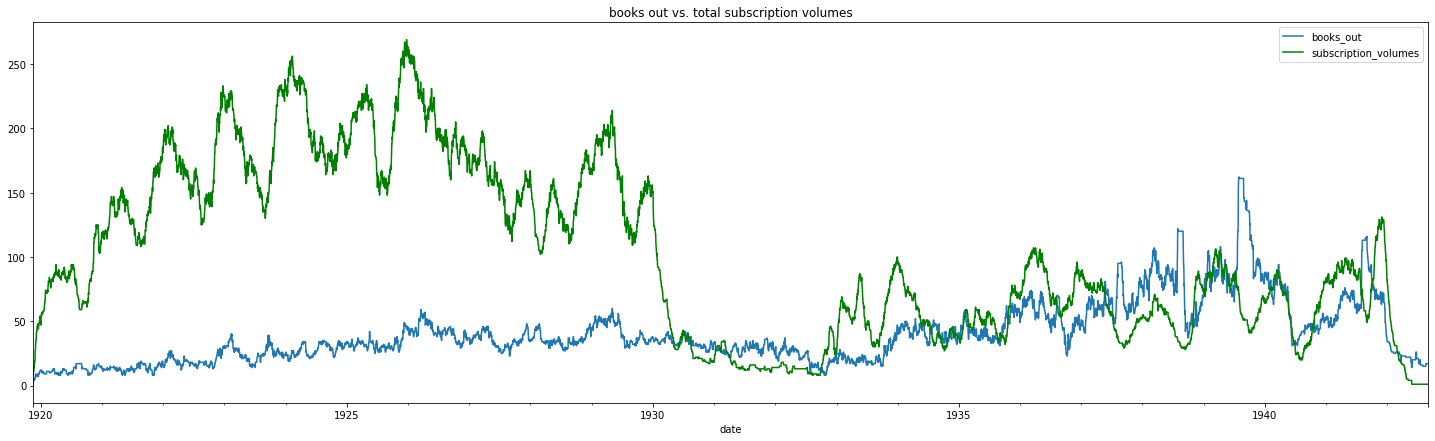

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# get current axis so we can plot two series on the same axis
ax = plt.gca()

borrowing_df.plot(kind='line',x='date',y='books_out',ax=ax, figsize=(25,7), title='books out vs. total subscription volumes')
borrowing_df.plot(kind='line',x='date',y='subscription_volumes', color='green', ax=ax)

plt.savefig('sco_borrowing_capacity.png')
plt.show()


In [17]:
# same plot but with altair

import altair as alt

# allow large datasets
alt.data_transformers.enable('default', max_rows=None)

chart_height = 275

base = alt.Chart(borrowing_df).encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=chart_height
)

line_books_out = base.mark_line(stroke='#5276A7', strokeWidth=1).encode(
    alt.Y('books_out',
          axis=alt.Axis(title='books out', titleColor='#5276A7'))
)

line_subs_vols = base.mark_line(stroke='green', strokeWidth=1).encode(
    alt.Y('subscription_volumes',
          axis=alt.Axis(title='subscription volumes', titleColor='green'))
)

line_books_out + line_subs_vols

alt.LayerChart(...)

In [22]:
borrowing_df

date  books_out  subscription_volumes  card_subscription_volumes
0    1919-11-17          0                   3.0                        1.0
1    1919-11-18          3                   9.0                        4.0
2    1919-11-19          5                  10.0                        5.0
3    1919-11-20          5                  11.0                        5.0
4    1919-11-21          5                  13.0                        5.0
...         ...        ...                   ...                        ...
8321 1942-08-29         17                   1.0                        1.0
8322 1942-08-30         17                   1.0                        1.0
8323 1942-08-31         17                   1.0                        1.0
8324 1942-09-01         17                   1.0                        1.0
8325 1942-09-02         17                   1.0                        1.0

[8326 rows x 4 columns]

In [24]:
# flatten for altair to get a better legend
books_out = borrowing_df.rename(columns={"books_out": "volumes"})[["date", "volumes"]]
books_out["activity"] = "Books out"

subs_vols = borrowing_df.rename(columns={"subscription_volumes": "volumes"})[["date", "volumes"]]
subs_vols["activity"] = "Subscription volumes"

alt_borrowing = pd.concat([books_out, subs_vols])
alt_borrowing

date  volumes              activity
0    1919-11-17      0.0             Books out
1    1919-11-18      3.0             Books out
2    1919-11-19      5.0             Books out
3    1919-11-20      5.0             Books out
4    1919-11-21      5.0             Books out
...         ...      ...                   ...
8321 1942-08-29      1.0  Subscription volumes
8322 1942-08-30      1.0  Subscription volumes
8323 1942-08-31      1.0  Subscription volumes
8324 1942-09-01      1.0  Subscription volumes
8325 1942-09-02      1.0  Subscription volumes

[16652 rows x 3 columns]

### Figure - Borrowing capacity analysis; subscription volume limit utilization for members with cards.

In [48]:

chart = alt.Chart(alt_borrowing).encode(
    alt.X('date:T', axis=alt.Axis(title='Duration of the Lending Library')),
).properties(
    width=1200,
    height=chart_height
)

books_out_vs_subs = chart.mark_line(strokeWidth=1).encode(
    alt.Y("volumes", axis=alt.Axis(title='Number of volumes')),
    color=alt.Color("activity", title="", scale=alt.Scale(range=["#5276A7", "green"]))
)
books_out_vs_subs


alt.Chart(...)

In [49]:
# figure 7
books_out_vs_subs.save("fig7-booksout_subs_volumes.json")

### chart: daily books out vs subscription volumes for members with extant card

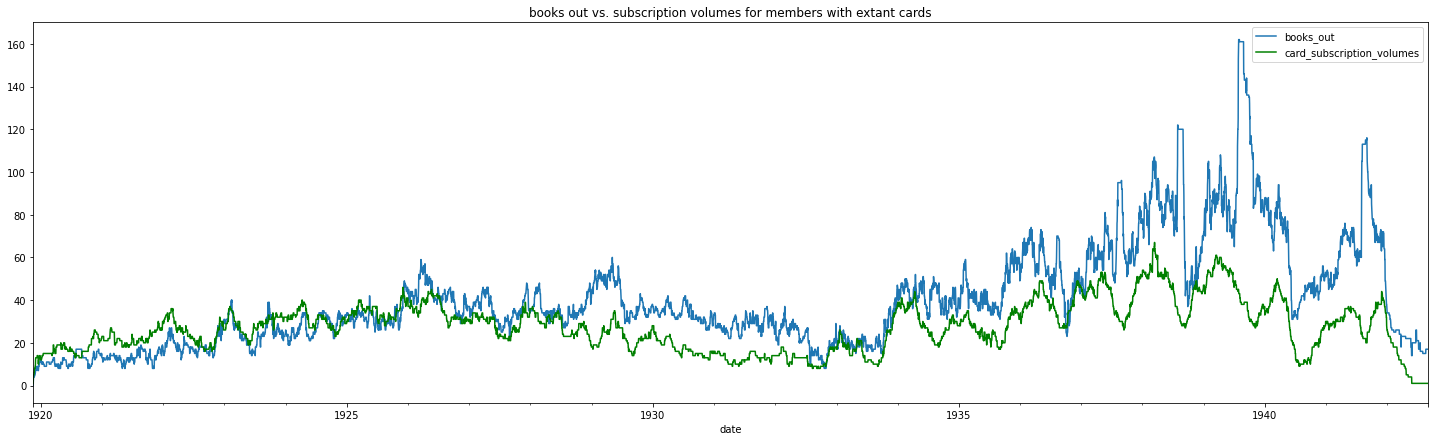

In [18]:
# same plot but limited to members with extant cards (any time, includes partial cards)
ax = plt.gca()
borrowing_df.plot(kind='line',x='date',y='books_out',ax=ax, figsize=(25,7),
                  title='books out vs. subscription volumes for members with extant cards')
borrowing_df.plot(kind='line',x='date',y='card_subscription_volumes', color='green', ax=ax)
plt.show()


In [21]:
# altair version of above


base = alt.Chart(borrowing_df).encode(
    alt.X('date:T', axis=alt.Axis(title='Duration of the Lending Library'))
).properties(
    width=1200,
    height=chart_height,
    title='Books out vs. Subscription volumes for members with extant cards'
)

line_cardsubs_vols = base.mark_line(stroke='green', strokeWidth=1).encode(
    alt.Y('card_subscription_volumes',
          axis=alt.Axis(title='number of volumes'))
)

line_books_out + line_cardsubs_vols

alt.LayerChart(...)

Based on this plot, we have a lot of borrowing going on beyond what the subscriptions indicate should have been allowed. Lots of friends and family borrowing? Overdue books that weren't counted against volume limits?

## percent of available subscription volumes used (members with extant cards)

In [ ]:
# calculate what percent of available subscription volumes was used (members with cards only)
borrowing_df['pct_used'] = borrowing_df.apply(lambda x: x.books_out / x.card_subscription_volumes, axis=1)
borrowing_df

date  books_out  subscription_volumes  card_subscription_volumes  \
0    1919-11-17          0                   3.0                        1.0   
1    1919-11-18          3                   9.0                        4.0   
2    1919-11-19          5                  10.0                        5.0   
3    1919-11-20          5                  11.0                        5.0   
4    1919-11-21          5                  13.0                        5.0   
...         ...        ...                   ...                        ...   
8321 1942-08-29         17                   1.0                        1.0   
8322 1942-08-30         17                   1.0                        1.0   
8323 1942-08-31         17                   1.0                        1.0   
8324 1942-09-01         17                   1.0                        1.0   
8325 1942-09-02         17                   1.0                        1.0   

      pct_used  
0         0.00  
1         0.75  
2         1.00  
3         1.00  
4         1.00  
...        ...  
8321     17.00  
8322     17.00  
8323     17.00  
8324     17.00  
8325     17.00  

[8326 rows x 5 columns]

In [ ]:
borrowing_df.pct_used.agg(['min', 'max', 'mean'])

min      0.000000
max     26.000000
mean     1.703751
Name: pct_used, dtype: float64

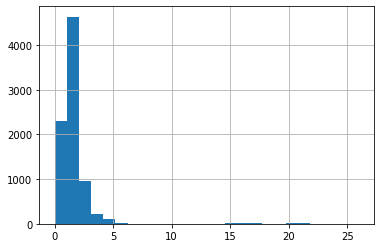

In [ ]:
borrowing_df.pct_used.hist(bins=25)

# limit to borrows and subscriptions that overlap

To calculate better based on partial borrowing records and borrowing without subscriptions, only consider subscriptions with at least one borrow and borrows that overlap with at least one subscription.

## identify borrows within subscriptions

In [ ]:
# identify borrows that occur with/without active subscriptions
# for each borrow event, check if there is a subscription event for the same first member uri 
# with any overlap in dates

# make a copy of the dataframe so pandas won't complain about setting values on a slice
borrow_events_df = borrow_events.copy()
# split out multiple member uris to match on member_subs df
borrow_events_df[['first_member_uri','second_member_uri']] = borrow_events_df.member_uris.str.split(';', expand=True)

def borrow_within_sub(borrow):
  return len(member_subs[(member_subs.first_member_uri == borrow.first_member_uri) & 
              (member_subs.start_date <= borrow.end_date) &
              (member_subs.end_date >= borrow.start_date)])

borrow_events_df['within_subscription'] = borrow_events_df.apply(borrow_within_sub, axis=1)
borrow_events_df.within_subscription.value_counts()



1    15622
0     2343
2     1737
3       83
4        3
6        1
Name: within_subscription, dtype: int64

In [ ]:
# inspect results
# borrows without subscription
borrow_events_df[borrow_events_df.within_subscription == 0]

event_type  start_date    end_date  \
768       Borrow  1920-01-12  1920-01-22   
779       Borrow  1920-01-22  1920-03-13   
830       Borrow  1920-03-13  1920-04-17   
865       Borrow  1920-04-13  1920-04-19   
863       Borrow  1920-04-13  1921-04-22   
...          ...         ...         ...   
29903     Borrow  1961-06-30  1961-10-04   
29904     Borrow  1961-06-30  1961-10-04   
29905     Borrow  1961-06-30  1961-10-04   
29908     Borrow  1961-10-04  1962-03-21   
29907     Borrow  1961-10-04  1962-03-21   

                                             member_uris       member_names  \
768    https://shakespeareandco.princeton.edu/members...  Blanche Reverchon   
779    https://shakespeareandco.princeton.edu/members...  Blanche Reverchon   
830    https://shakespeareandco.princeton.edu/members...  Blanche Reverchon   
865    https://shakespeareandco.princeton.edu/members...      André Maurois   
863    https://shakespeareandco.princeton.edu/members...      André Maurois   
...                                                  ...                ...   
29903  https://shakespeareandco.princeton.edu/members...      Henri Michaux   
29904  https://shakespeareandco.princeton.edu/members...      Henri Michaux   
29905  https://shakespeareandco.princeton.edu/members...      Henri Michaux   
29908  https://shakespeareandco.princeton.edu/members...          Ann Samyn   
29907  https://shakespeareandco.princeton.edu/members...          Ann Samyn   

        member_sort_names  subscription_price_paid  subscription_deposit  \
768    Reverchon, Blanche                      NaN                   NaN   
779    Reverchon, Blanche                      NaN                   NaN   
830    Reverchon, Blanche                      NaN                   NaN   
865        Maurois, André                      NaN                   NaN   
863        Maurois, André                      NaN                   NaN   
...                   ...                      ...                   ...   
29903      Michaux, Henri                      NaN                   NaN   
29904      Michaux, Henri                      NaN                   NaN   
29905      Michaux, Henri                      NaN                   NaN   
29908          Samyn, Ann                      NaN                   NaN   
29907          Samyn, Ann                      NaN                   NaN   

      subscription_duration  subscription_duration_days  ...  \
768                     NaN                         NaN  ...   
779                     NaN                         NaN  ...   
830                     NaN                         NaN  ...   
865                     NaN                         NaN  ...   
863                     NaN                         NaN  ...   
...                     ...                         ...  ...   
29903                   NaN                         NaN  ...   
29904                   NaN                         NaN  ...   
29905                   NaN                         NaN  ...   
29908                   NaN                         NaN  ...   
29907                   NaN                         NaN  ...   

                                              item_notes  \
768                                                  NaN   
779                                                  NaN   
830                                                  NaN   
865                                                  NaN   
863                                                  NaN   
...                                                  ...   
29903  At least two sets of De Quincey's works circul...   
29904  At least two sets of De Quincey's works circul...   
29905  At least two sets of De Quincey's works circul...   
29908                                                NaN   
29907                                                NaN   

                source_type  \
768    Lending Library Card   
779    Lending Library Card   
830    Lending Library Card   
8

In [ ]:
borrow_events_df[borrow_events_df.within_subscription == 0].member_names.value_counts()

Mlle Ottocar                               104
François Valéry                            101
Bravig Imbs                                 76
Jeanne Fournier                             73
Dorothy Plummer                             73
                                          ... 
M. Villars                                   1
Mary Sophie Ludlow                           1
Andrée (Hirsch) Pelorson / Mme Pelorson      1
Max Christian Wegner                         1
Nathalie Sarraute                            1
Name: member_names, Length: 230, dtype: int64

preliminary inspection of borrows occurring outside of subscriptions 

- Blanch Reverchon: subs Dec 1919 - Jan 1920, but borrows continue into March and April
- André Maurois: 3month sub Dec 1919 - March 1920; borrowing continues into March and April
- Henri Michaux: no documented subscriptions; borrow events 1944; 1950 – 1951; 1955; 1961 (all after bookshop officiall closed)
- Mlle Ottocar: subs 1921-1927, partial in 1929; borrow events 1920-1931
- François Valéry: no documented subscriptions; most likely Beach let him borrow without one
- Jeanne Fournier: subs 1925-1930; borrows 1925-1931 (likely missing subs due to missing 1930s logbooks)
- Bravig Imbs: subs 1925, 1928; borrows 1927-1931
- Dorothy Plummer: only one 1m sub in 1936; borrow events 1931-1937


In [ ]:
# borrows overlapping with multiple subscriptions
borrow_events_df[borrow_events_df.within_subscription > 2]

event_type  start_date    end_date  \
1135      Borrow  1920-12-04  1920-12-09   
1139      Borrow  1920-12-04  1920-12-09   
1143      Borrow  1920-12-09  1920-12-13   
1146      Borrow  1920-12-09  1920-12-13   
2680      Borrow  1923-01-10  1923-02-24   
...          ...         ...         ...   
28070     Borrow  1941-03-18  1941-03-24   
28285     Borrow  1941-04-26  1941-05-29   
28297     Borrow  1941-04-28  1941-05-29   
28296     Borrow  1941-04-28  1941-05-29   
29069     Borrow  1941-10-15  1941-12-01   

                                             member_uris  \
1135   https://shakespeareandco.princeton.edu/members...   
1139   https://shakespeareandco.princeton.edu/members...   
1143   https://shakespeareandco.princeton.edu/members...   
1146   https://shakespeareandco.princeton.edu/members...   
2680   https://shakespeareandco.princeton.edu/members...   
...                                                  ...   
28070  https://shakespeareandco.princeton.edu/members...   
28285  https://shakespeareandco.princeton.edu/members...   
28297  https://shakespeareandco.princeton.edu/members...   
28296  https://shakespeareandco.princeton.edu/members...   
29069  https://shakespeareandco.princeton.edu/members...   

                                            member_names  \
1135                                       Mlle Tournier   
1139                                       Mlle Tournier   
1143                                       Mlle Tournier   
1146                                       Mlle Tournier   
2680   Miss Somerville and Miss Somerville / The Miss...   
...                                                  ...   
28070                               Mrs. Emory Whitridge   
28285                                       Fred Davaine   
28297                                      Mme Schueller   
28296                                      Mme Schueller   
29069                                      Jacques Lacan   

            member_sort_names  subscription_price_paid  subscription_deposit  \
1135           Tournier, Mlle                      NaN                   NaN   
1139           Tournier, Mlle                      NaN                   NaN   
1143           Tournier, Mlle                      NaN                   NaN   
1146           Tournier, Mlle                      NaN                   NaN   
2680   Somerville, The Misses                      NaN                   NaN   
...                       ...                      ...                   ...   
28070   Whitridge, Mrs. Emory                      NaN                   NaN   
28285           Davaine, Fred                      NaN                   NaN   
28297          Schueller, Mme                      NaN                   NaN   
28296          Schueller, Mme                      NaN                   NaN   
29069          Lacan, Jacques                      NaN                   NaN   

      subscription_duration  subscription_duration_days  ...  item_notes  \
1135                    NaN                         NaN  ...         NaN   
1139                    NaN                         NaN  ...         NaN   
1143                    NaN                         NaN  ...         NaN   
1146                    NaN                         NaN  ...         NaN   
2680                    NaN                         NaN  ...         NaN   
...                     ...                         ...  ...         ...   
28070                   NaN                         NaN  ...         NaN   
28285                   NaN                         NaN  ...         NaN   
28297                   NaN                         NaN  ...         NaN   
28296                   NaN                         NaN  ...         NaN   
29069                   NaN                         NaN  ...         NaN   

                source_type  \
1135   Lending Library Card   
1139   Lending Library Card   
1143   Lending Library Card   
1146   Lending Library Card   
2680  

In [ ]:
borrow_events_df[borrow_events_df.within_subscription > 2].member_names.value_counts()

Leo Stein                                                     11
Stanislas Pascal Franchot                                      6
Mlle Tournier                                                  4
Raymonde Lamirault                                             4
Renée Antoine-May                                              4
Mrs. Jackson                                                   4
Eda Lord                                                       4
Mrs. Thornton Baker                                            3
Anatole Rivoallan                                              3
Fanny Rirachowsky                                              2
Mme Schueller                                                  2
Mrs. Emory Whitridge                                           2
Eric Culley                                                    2
Louise Olga Bouniols                                           2
Adelaide W. Massey / A. W. Massey                              2
E. M. Churchill          

preliminary inspection of borrows occurring overlapping with > 2 subscriptions 

Would expect to see this for borrows that start under one subscription and end in another AND for members who purchased a supplement

- Leo Stein: supplement apr 8 - may 8 1924; 3 books borrowed May 7 would overlap with march 2 renewal, apr 8 supplement, may 18 renewal? (possible data error here: 2m 15 day renewal may 13-jul 28 overlaps with june 2 renewal)
- Franchot: 2 overlapping supplements

Some of these have odd-looking subscriptions, could be data errors in subscription dates (Eda Lord, Rivoallan), but calculation seems to be reasonable based on the data we have now

## annotate subscriptions with borrow count

In [ ]:
# identify subscriptions with at least one overlapping borrow
# for each subscription event, count the number of borrow events for the same first member uri with any overlap in start/end dates

# make a copy of the dataframe so pandas won't complain about setting values on a slice
member_subs_df = member_subs.copy()

def borrows_within_sub(sub):
  return len(borrow_events_df[
        (borrow_events_df.first_member_uri == sub.first_member_uri) &
        (borrow_events_df.start_date <= sub.end_date) &
        (borrow_events_df.end_date >= sub.start_date)])


member_subs_df['borrow_count'] = member_subs_df.apply(borrows_within_sub, axis=1)
member_subs_df.borrow_count.value_counts()

0      252
3      156
4      144
5      138
2      121
      ... 
87       1
61       1
159      1
133      1
109      1
Name: borrow_count, Length: 83, dtype: int64

In [ ]:
# subscriptions with no borrows
member_subs_df[member_subs_df.borrow_count == 0]

event_type  start_date    end_date  \
30    Subscription  1919-11-22  1920-11-22   
31    Subscription  1920-12-31  1921-06-30   
32         Renewal  1921-08-25  1922-02-25   
46    Subscription  1919-11-24  1920-05-24   
47         Renewal  1921-02-18  1921-05-18   
...            ...         ...         ...   
8532  Subscription  1940-02-02  1940-03-02   
8701  Subscription  1940-09-30  1940-10-30   
8968  Subscription  1941-12-02  1942-01-02   
9051  Subscription  1941-10-30  1941-11-30   
9074  Subscription  1941-11-28  1941-12-28   

                                            member_uris  \
30    https://shakespeareandco.princeton.edu/members...   
31    https://shakespeareandco.princeton.edu/members...   
32    https://shakespeareandco.princeton.edu/members...   
46    https://shakespeareandco.princeton.edu/members...   
47    https://shakespeareandco.princeton.edu/members...   
...                                                 ...   
8532  https://shakespeareandco.princeton.edu/members...   
8701  https://shakespeareandco.princeton.edu/members...   
8968  https://shakespeareandco.princeton.edu/members...   
9051  https://shakespeareandco.princeton.edu/members...   
9074  https://shakespeareandco.princeton.edu/members...   

                                  member_names       member_sort_names  \
30                          Marie Boscq / Bosq            Boscq, Marie   
31                          Marie Boscq / Bosq            Boscq, Marie   
32                          Marie Boscq / Bosq            Boscq, Marie   
46                               Mrs. Bernheim          Bernheim, Mrs.   
47                               Mrs. Bernheim          Bernheim, Mrs.   
...                                        ...                     ...   
8532                             Mrs. Quennell          Quennell, Mrs.   
8701  Simone Abreu / Mme Simone de Bretteville  de Bretteville, Simone   
8968                               Odile Brull            Brull, Odile   
9051                                  Jean Roy               Roy, Jean   
9074                        Bernard Lestocquoy     Lestocquoy, Bernard   

      subscription_price_paid  subscription_deposit subscription_duration  \
30                       28.0                   7.0                1 year   
31                       28.0                   NaN              6 months   
32                       35.0                   NaN              6 months   
46                       16.0                   NaN              6 months   
47                       16.0                   NaN              3 months   
...                       ...                   ...                   ...   
8532                     45.0                  50.0               1 month   
8701                     25.0                  50.0               1 month   
8968                     20.0                   NaN               1 month   
9051                     20.0                  50.0               1 month   
9074                     25.0                  50.0               1 month   

      subscription_duration_days  ...  viaf_url wikipedia_url nationalities  \
30                         366.0  ...       NaN           NaN           NaN   
31                         181.0  ...       NaN           NaN           NaN   
32                         184.0  ...       NaN           NaN           NaN   
46                         182.0  ...       NaN           NaN           NaN   
47                          89.0  ...       NaN           NaN           NaN   
...                          ...  ...       ...           ...           ...   
8532                        29.0  ...       NaN           NaN           NaN   
8701                        30.0  ...       NaN           NaN        France   
8968                        31.0  ...       NaN           NaN           NaN   
9051                        31.0  ...       NaN           NaN           NaN   
9074                        30.0  ...       NaN           NaN  

Preliminary inspection of subscriptions with no borrows — calculation looks reasonable

- Marie Boscq: subs in 1920-21 but borrowing not documented until 1932
- Mrs. Berheim: similar: no borrowing records for early subscriptiosn (1920s)
- Mrs. Quennell: 1m sub in 1940; 1 borrow in 1940 with no end date 

## calculate daily books out vs subscription volumes for overlapping borrows/subscriptions

In [ ]:
# repeat the same plot but limited to borrows and subscriptions that overlap

# subscription events with at least one borrow
subs_with_borrows = member_subs_df[member_subs_df.borrow_count != 0] 
# borrows that overlap with a subscription
borrows_within_subs = borrow_events_df[borrow_events_df.within_subscription != 0]

# adapt previous code rerun with the filtered events 
# go through end of last subscription end date
one_day = timedelta(days=1)
# start with the earliest start date
day = date_events.start_datetime.iloc[0]

overlap_dates = []
overlap_books_out = []
overlap_subscription_vols = []

while day < subs_end_date:
     overlap_dates.append(day)
     # get total number of borrowing events (within subscriptions) spanning this date; include start date, exclude end (to avoid double counting)
     overlap_books_out.append(len(borrows_within_subs[(borrows_within_subs.start_datetime <= day) & (borrows_within_subs.end_datetime > day)]))
     # total number of volumes from active subscriptions (with borrows) for this date
     overlap_subscription_vols.append(subs_with_borrows[(subs_with_borrows.start_datetime <= day) & (day < subs_with_borrows.end_datetime)].subscription_volumes.sum())

     day += one_day

overlap_borrowing_df  = pd.DataFrame()
overlap_borrowing_df['date'] = overlap_dates
overlap_borrowing_df['books_out'] = overlap_books_out
overlap_borrowing_df['subscription_volumes'] = overlap_subscription_vols
overlap_borrowing_df

date  books_out  subscription_volumes
0    1919-11-17          0                   1.0
1    1919-11-18          3                   4.0
2    1919-11-19          5                   5.0
3    1919-11-20          5                   5.0
4    1919-11-21          5                   5.0
...         ...        ...                   ...
8321 1942-08-29          2                   1.0
8322 1942-08-30          2                   1.0
8323 1942-08-31          2                   1.0
8324 1942-09-01          2                   1.0
8325 1942-09-02          2                   1.0

[8326 rows x 3 columns]

### chart: borrows vs subscription volumes

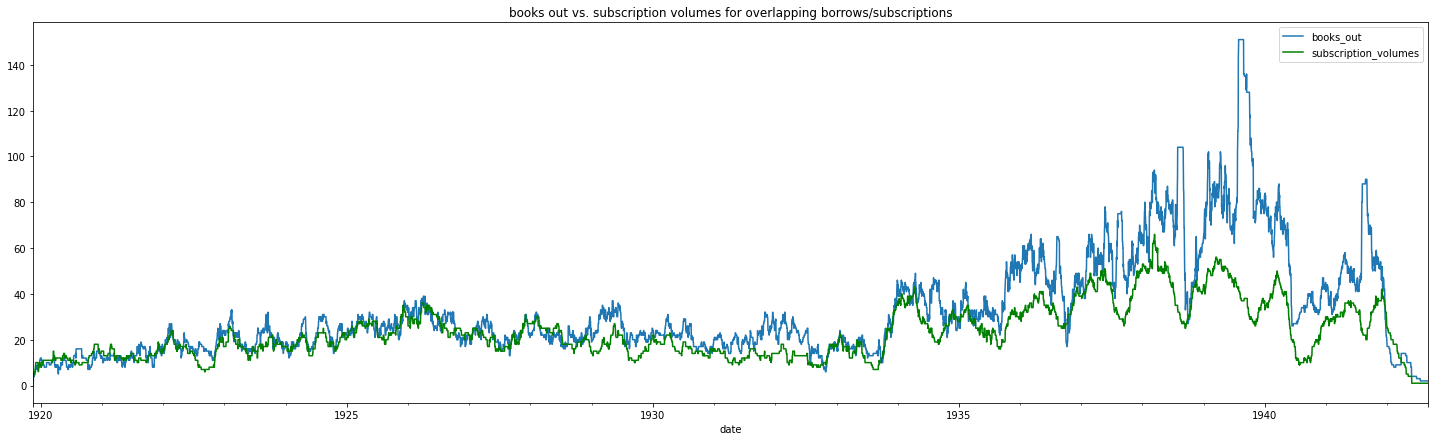

In [ ]:
ax = plt.gca()
overlap_borrowing_df.plot(kind='line',x='date',y='books_out',ax=ax, figsize=(25,7),
                   title='books out vs. subscription volumes for overlapping borrows/subscriptions')
overlap_borrowing_df.plot(kind='line',x='date',y='subscription_volumes', color='green', ax=ax)
plt.show()

In this version of the graph, the books out and subscription volumes track each other much more closely through the early 1930s. Still not sure what is going on after 1935! I thought limiting to overlapping subscriptions and borrows would make this clearer. Are there data errors? Did I not limit things the way I thought? Did Beach get more lax in enforcing subscription limits? Could including long checkouts be skewing the results?




In [ ]:
overlap_borrowing_df.head()

date  books_out  subscription_volumes
0 1919-11-17          0                   1.0
1 1919-11-18          3                   4.0
2 1919-11-19          5                   5.0
3 1919-11-20          5                   5.0
4 1919-11-21          5                   5.0

In [ ]:
# consolidate into the structure altair wants for multiline charts, to simplify graphing with altair
overlap_books_out = overlap_borrowing_df.rename(columns={"date": "date", "books_out": "total"})
overlap_books_out['type'] = "books out"

overlap_subs_vols = overlap_borrowing_df.rename(columns={"date": "date", "subscription_volumes": "total"})
overlap_subs_vols['type'] = "subscription volumes"


alt_overlap_borrowing = pd.concat([overlap_books_out, overlap_subs_vols])


color_domain = ['books out', 'subscription volumes']
color_range = ['#5276A7', 'green']


alt.Chart(alt_overlap_borrowing).mark_line(strokeWidth=0.75).encode(
    x='date',
    y='total',
    color=alt.Color('type', scale=alt.Scale(domain=color_domain, range=color_range), title="")
).properties(
    width=1200,
    height=chart_height,
    title='books out vs. subscription volumes for overlapping borrows/subscriptions'
)



alt.Chart(...)

## percent of available subscription volumes used

In [ ]:
# calculate what percent of available subscription volumes was used
overlap_borrowing_df['pct_used'] = overlap_borrowing_df.apply(lambda x: x.books_out / x.subscription_volumes, axis=1)
overlap_borrowing_df

date  books_out  subscription_volumes  pct_used
0    1919-11-17          0                   1.0      0.00
1    1919-11-18          3                   4.0      0.75
2    1919-11-19          5                   5.0      1.00
3    1919-11-20          5                   5.0      1.00
4    1919-11-21          5                   5.0      1.00
...         ...        ...                   ...       ...
8321 1942-08-29          2                   1.0      2.00
8322 1942-08-30          2                   1.0      2.00
8323 1942-08-31          2                   1.0      2.00
8324 1942-09-01          2                   1.0      2.00
8325 1942-09-02          2                   1.0      2.00

[8326 rows x 4 columns]

In [ ]:
overlap_borrowing_df.pct_used.agg(['min', 'max', 'mean'])

min     0.0000
max     4.5000
mean    1.3994
Name: pct_used, dtype: float64

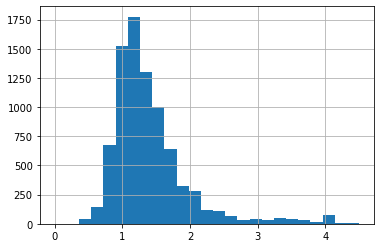

In [ ]:
overlap_borrowing_df.pct_used.hist(bins=25)

# preliminary conclusion

Using the known subscription volumes as a **minimum** for likely book activity seems reasonable. Available evidence suggests there was _more_ borrowing going on than that, at least in the later years.